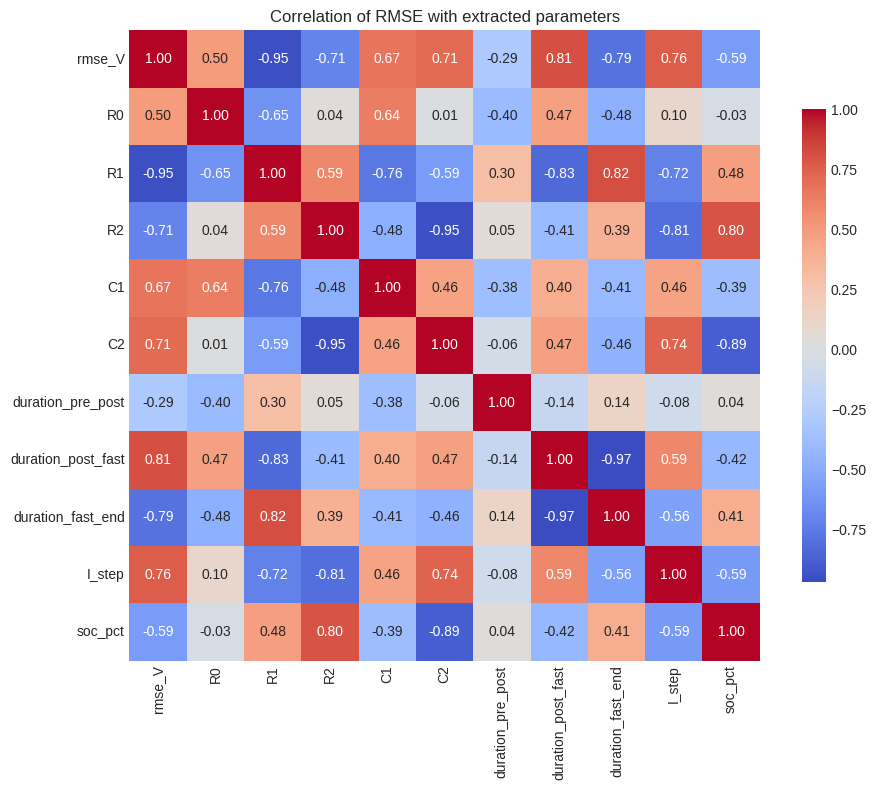

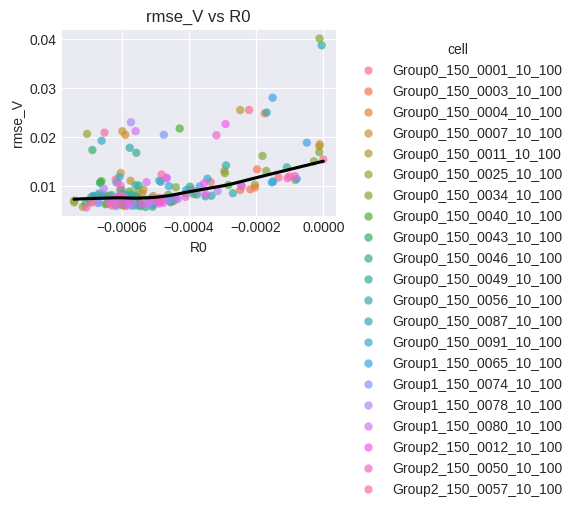

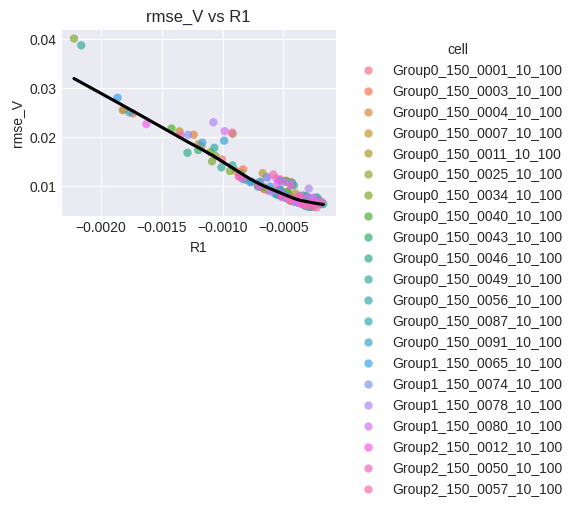

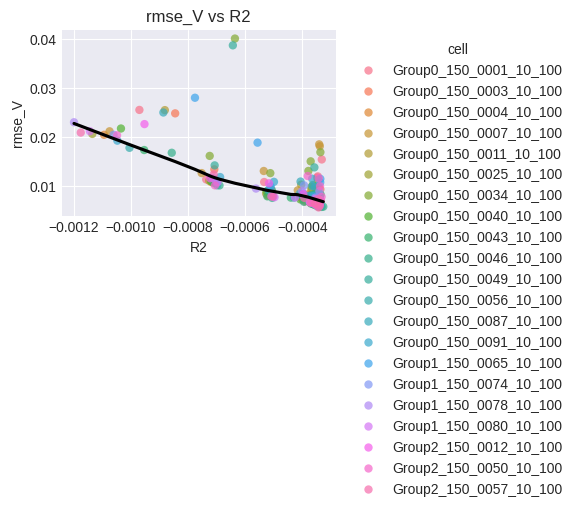

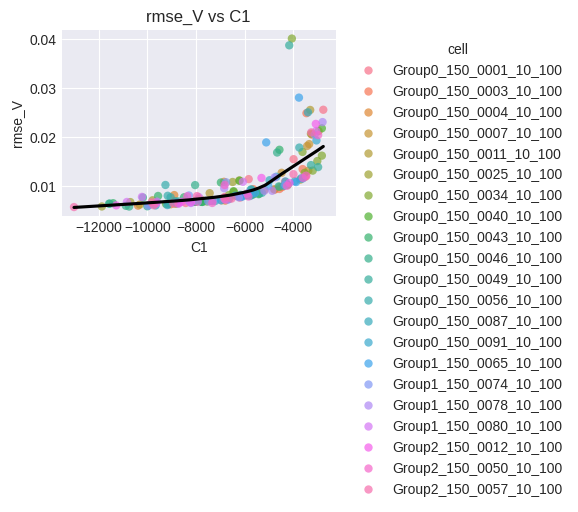

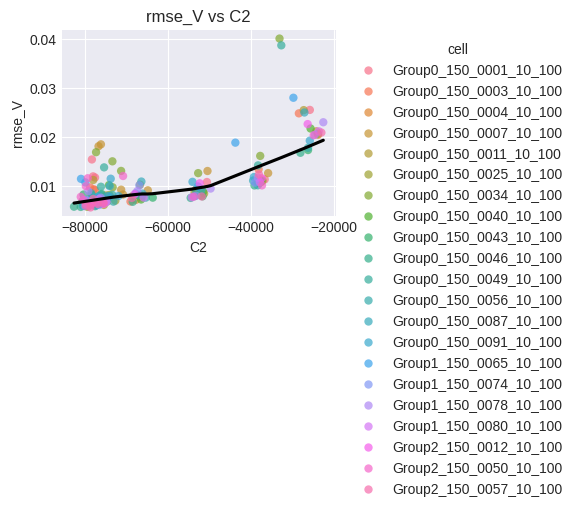

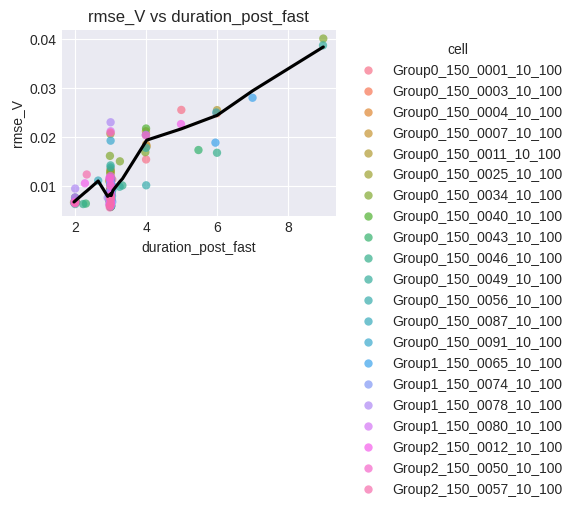

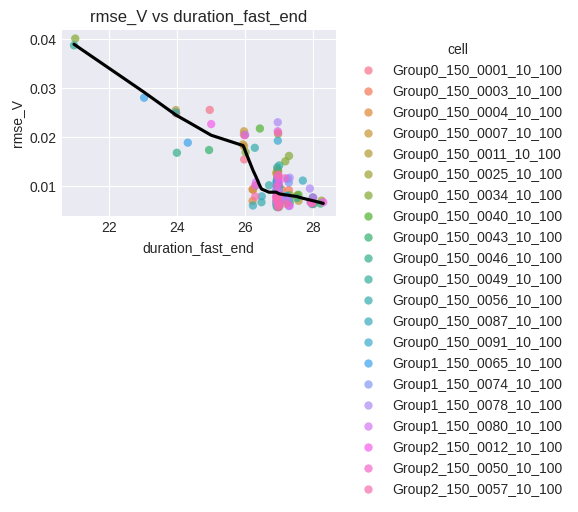

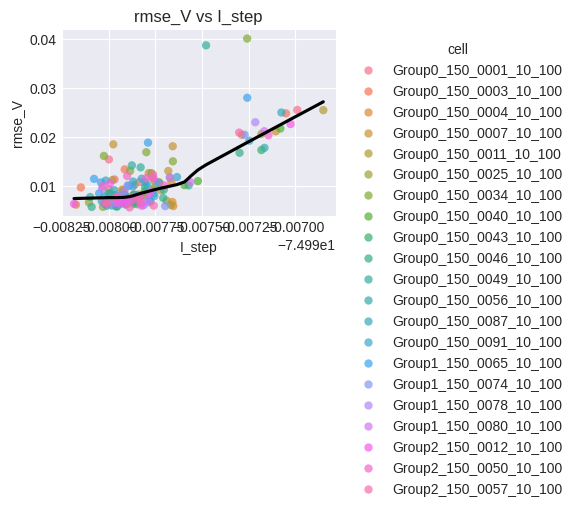

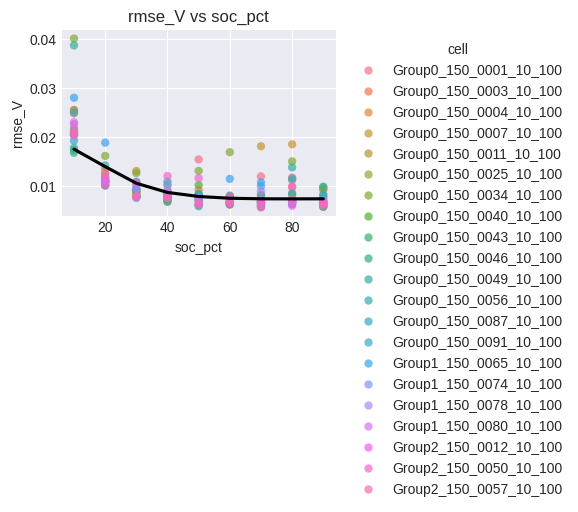

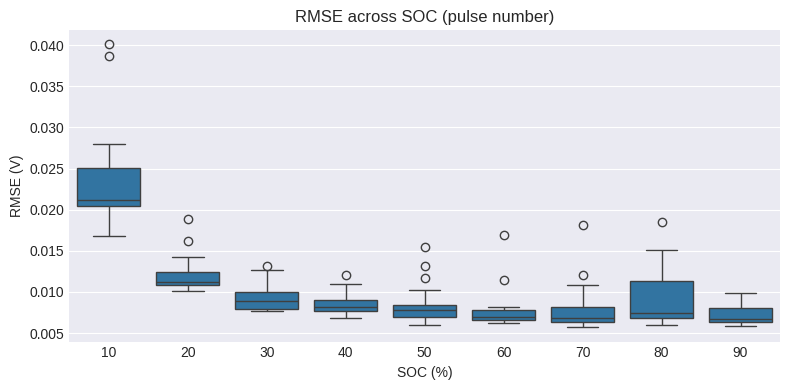

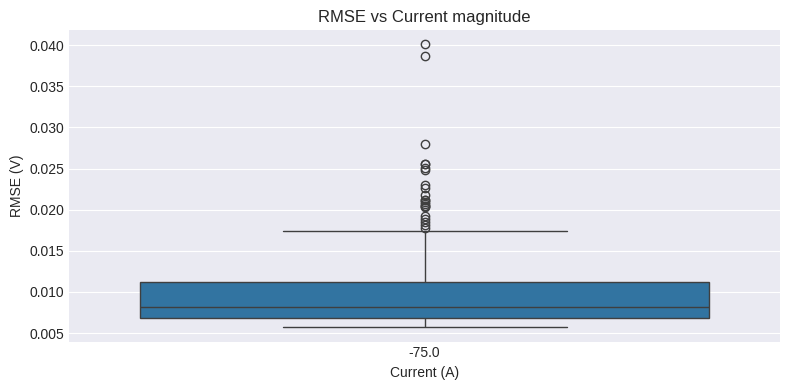

/tmp/ipykernel_8009/670952977.py:155: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_seg = grp.groupby("segment")["error_V"].agg(["mean", "std"]).reset_index()
/tmp/ipykernel_8009/670952977.py:155: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_seg = grp.groupby("segment")["error_V"].agg(["mean", "std"]).reset_index()
/tmp/ipykernel_8009/670952977.py:155: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summar

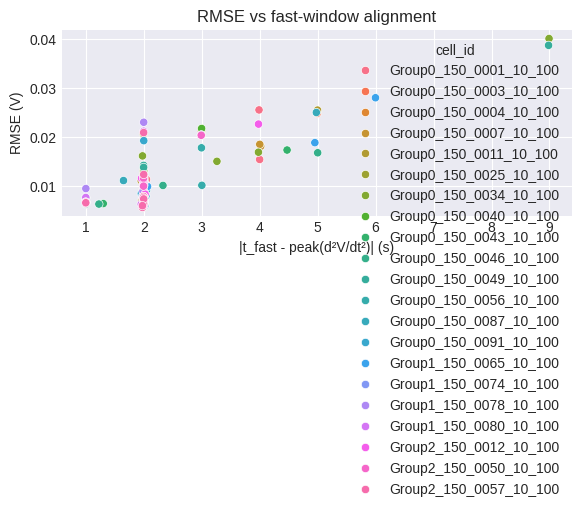

Finished. Outputs saved to /home/kcv/Desktop/HPPC_post_processing/post_processing/analysis_results


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
from pathlib import Path

plt.style.use("seaborn-v0_8-darkgrid")

RESIST_DIR = Path("/home/kcv/Desktop/HPPC_post_processing/post_processing/data/optimiser_results/resistances")
TV_DIR = Path("/home/kcv/Desktop/HPPC_post_processing/post_processing/data/optimiser_results/terminal_voltage_estimation")
DERIV_DIR = Path("/home/kcv/Desktop/HPPC_post_processing/post_processing/data/optimiser_results/voltage_derivatives")
OUT_DIR = Path("/home/kcv/Desktop/HPPC_post_processing/post_processing/analysis_results")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ----------------------------------------------------------------------
# Load optimiser summaries
# ----------------------------------------------------------------------
summary_frames = []
for csv_path in sorted(RESIST_DIR.glob("*_resistance_summary.csv")):
    df = pd.read_csv(csv_path)
    if df.empty:
        continue
    df["cell"] = csv_path.stem.replace("_resistance_summary", "")
    df["pulse_no"] = np.arange(1, len(df) + 1)
    df["soc_pct"] = (df["pulse_no"] * 10).clip(upper=100)
    summary_frames.append(df)

summary = pd.concat(summary_frames, ignore_index=True)
summary = summary.rename(columns={"Cycle No": "cycle", "Step No": "step"})
summary["cycle"] = summary["cycle"].astype(int)
summary["step"] = summary["step"].astype(int)
summary["cell_id"] = summary["cell"].str.replace("RD_LFP_HPPC_REPT_", "", regex=False)
summary.to_csv(OUT_DIR / "all_cells_resistance_summary.csv", index=False)

# Terminal-voltage data
tv_frames = []
for csv_path in sorted(TV_DIR.glob("*_terminal_voltage.csv")):
    df = pd.read_csv(csv_path)
    if df.empty:
        continue
    df["cell"] = csv_path.stem.replace("_terminal_voltage", "")
    df["cell_id"] = df["cell"].str.replace("RD_LFP_HPPC_REPT_", "", regex=False)
    tv_frames.append(df)

tv = pd.concat(tv_frames, ignore_index=True)
tv.to_csv(OUT_DIR / "all_cells_terminal_voltage_samples.csv", index=False)

# Pulse-level RMSE
pulse_rmse = (
    tv.groupby(["cell", "cycle", "step", "pulse_no"])["error_V"]
    .apply(lambda s: np.sqrt(np.mean(np.square(s))))
    .reset_index(name="rmse_V")
)

merged = summary.merge(
    pulse_rmse,
    on=["cell", "cycle", "step", "pulse_no"],
    how="left",
)
merged.to_csv(OUT_DIR / "merged_pulse_level_metrics.csv", index=False)

# ----------------------------------------------------------------------
# Correlations
# ----------------------------------------------------------------------
corr_cols = [
    "rmse_V",
    "R0",
    "R1",
    "R2",
    "C1",
    "C2",
    "duration_pre_post",
    "duration_post_fast",
    "duration_fast_end",
    "I_step",
    "soc_pct",
]
corr = merged[corr_cols].corr()
corr.to_csv(OUT_DIR / "rmse_correlations.csv")

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": 0.75})
plt.title("Correlation of RMSE with extracted parameters")
plt.tight_layout()
plt.savefig(OUT_DIR / "rmse_correlation_heatmap.png", dpi=200)
plt.show()

# ----------------------------------------------------------------------
# Scatter plots (inline display with short cell IDs)
# ----------------------------------------------------------------------
pairs = [
    ("R0", "rmse_V"),
    ("R1", "rmse_V"),
    ("R2", "rmse_V"),
    ("C1", "rmse_V"),
    ("C2", "rmse_V"),
    ("duration_post_fast", "rmse_V"),
    ("duration_fast_end", "rmse_V"),
    ("I_step", "rmse_V"),
    ("soc_pct", "rmse_V"),
]
for x_col, y_col in pairs:
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.scatterplot(
        data=merged,
        x=x_col,
        y=y_col,
        hue="cell_id",
        alpha=0.7,
        edgecolor="none",
        ax=ax,
    )
    sns.regplot(data=merged, x=x_col, y=y_col, scatter=False, color="black", lowess=True, ax=ax)
    ax.set_title(f"{y_col} vs {x_col}")
    ax.legend(title="cell", bbox_to_anchor=(1.02, 1), loc="upper left")
    fig.tight_layout()
    fig.savefig(OUT_DIR / f"scatter_{y_col}_vs_{x_col}.png", dpi=180)
    plt.show()

# ----------------------------------------------------------------------
# SOC / current sensitivity boxplots
# ----------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(data=merged, x=pd.Categorical(merged["soc_pct"], ordered=True), y="rmse_V", ax=ax)
ax.set_xlabel("SOC (%)")
ax.set_ylabel("RMSE (V)")
ax.set_title("RMSE across SOC (pulse number)")
fig.tight_layout()
fig.savefig(OUT_DIR / "rmse_boxplot_soc.png", dpi=200)
plt.show()

fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(data=merged, x=np.round(merged["I_step"], 1), y="rmse_V", ax=ax)
ax.set_xlabel("Current (A)")
ax.set_ylabel("RMSE (V)")
ax.set_title("RMSE vs Current magnitude")
fig.tight_layout()
fig.savefig(OUT_DIR / "rmse_boxplot_current.png", dpi=200)
plt.show()

# ----------------------------------------------------------------------
# Residual profile by early/mid/late segments
# ----------------------------------------------------------------------
residual_bins = []
for (cell, cycle, step, pulse_no), group in tv.groupby(["cell", "cycle", "step", "pulse_no"]):
    grp = group.sort_values("time_s").copy()
    rel_t = grp["time_s"] - grp["time_s"].iloc[0]
    span = rel_t.iloc[-1]
    if span <= 0:
        continue
    frac = rel_t / span
    grp = grp.assign(time_frac=frac)
    grp["segment"] = pd.cut(frac, bins=[0, 0.1, 0.5, 1.0], labels=["early", "mid", "late"])
    summary_seg = grp.groupby("segment")["error_V"].agg(["mean", "std"]).reset_index()
    summary_seg["cell_id"] = grp["cell_id"].iloc[0]
    summary_seg["pulse_no"] = pulse_no
    residual_bins.append(summary_seg)

if residual_bins:
    residual_profile = pd.concat(residual_bins, ignore_index=True)
    residual_profile.to_csv(OUT_DIR / "residual_profile_by_segment.csv", index=False)

# ----------------------------------------------------------------------
# t_fast alignment check
# ----------------------------------------------------------------------
fast_mismatch = []
for _, row in summary.iterrows():
    deriv_path = DERIV_DIR / f"{row['cell']}_cycle{int(row['cycle'])}_step{int(row['step'])}_derivatives.csv"
    if not deriv_path.exists():
        continue
    deriv = pd.read_csv(deriv_path)
    mask = (deriv["time_s"] >= row["t_post"]) & (deriv["time_s"] <= row["t_post"] + 5)
    window = deriv.loc[mask]
    if window.empty or window["d2v_dt2"].abs().max() == 0:
        continue
    peak_time = window.loc[window["d2v_dt2"].abs().idxmax(), "time_s"]
    mismatch = abs(peak_time - row["t_fast"])
    fast_mismatch.append(
        {"cell": row["cell"], "cell_id": row["cell_id"], "cycle": row["cycle"], "step": row["step"], "pulse_no": row["pulse_no"], "fast_alignment_error_s": mismatch}
    )

if fast_mismatch:
    fast_df = pd.DataFrame(fast_mismatch)
    merged_fast = merged.merge(fast_df, on=["cell", "cell_id", "cycle", "step", "pulse_no"], how="left")
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.scatterplot(data=merged_fast, x="fast_alignment_error_s", y="rmse_V", hue="cell_id", ax=ax)
    ax.set_xlabel("|t_fast - peak(d²V/dt²)| (s)")
    ax.set_ylabel("RMSE (V)")
    ax.set_title("RMSE vs fast-window alignment")
    fig.tight_layout()
    fig.savefig(OUT_DIR / "rmse_vs_fast_alignment_error.png", dpi=200)
    plt.show()
else:
    merged_fast = merged.copy()

# ----------------------------------------------------------------------
# Residual shapes PDF (still saved for offline review)
# ----------------------------------------------------------------------
pdf_path = OUT_DIR / "residual_shapes.pdf"
with PdfPages(pdf_path) as pdf:
    for (cell, cycle, step, pulse_no), group in tv.groupby(["cell", "cycle", "step", "pulse_no"]):
        group = group.sort_values("time_s").copy()
        rel_t = group["time_s"] - group["time_s"].iloc[0]
        fig, ax = plt.subplots(figsize=(8, 3))
        ax.plot(rel_t, group["error_V"], color="#d62728")
        ax.axhline(0, color="black", linewidth=0.8)
        ax.set_title(f"{cell} — Pulse {int(pulse_no)} Residual (cycle {int(cycle)}, step {int(step)})")
        ax.set_xlabel("Time since pulse start (s)")
        ax.set_ylabel("Voltage error (V)")
        pdf.savefig(fig, bbox_inches="tight")
        plt.close(fig)

print(f"Finished. Outputs saved to {OUT_DIR}")
